In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Resolvemos los ejercicios de TP1 y TP2 usando árboles de decisión


## TP1 - Regresión de calidad de vino portugués "Vinho Verde"

En el TP1 se trabajó con un dataset de vinos portugués "Vinho Verde" en la variante tinta. Se cuenta con variables fisicoquímicas (entradas) y un puntaje de clasificación de tipo de vino. El análisis lo hicimos en el TP1, aquí vamos a ir directamente a implementar el modelo.

Por lo que primero leemos el dataset y preparamos todo, igual que en el TP1.

In [ ]:
# Leemos el dataset
wine_df = pd.read_csv("winequality-red.csv")
# Obtenemos a X e y.
# Para X usamos todas las columnas menos el target
X = wine_df.drop(columns="quality")
y = wine_df["quality"]

print(f"La forma de X es {X.shape}")
print(f"La forma de y es {y.shape}")

# Separamos el dataset en training y test
from sklearn.model_selection import train_test_split

# Como no hay una buena distribucion de valores entre las calidades de vino, usamos el argumento opcional
# para que se mantenga la proporcion en los conjuntos de entrenamiento y testeo.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Como estamos trabajando con arboles, no vamos a realizar ninguna normalización

# Cargamos las metricas de evaluación que usamos en el TP1
from sklearn.metrics import r2_score, mean_absolute_error

La forma de X es (1599, 11)
La forma de y es (1599,)


Ya con el dataset leido y separado el entrenamiento y validación, podemos a realizar el entrenamiento.

Antes de entrenar el modelo, vamos a realizar una busqueda de hiperparametros. Vamos a usar una validación cruzada de 5 folds y una busqueda de grilla.

Para este caso vamos usar el podado de arboles, usando el coeficiente alpha (la busqueda tambien se podria haber hecho jugando con niveles del arbol o cantidad de muestra por hoja).

In [ ]:
# Llamamos a GridSearch de sklearn
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [ ]:
# Creamos el modelo base para buscar los hiperparametros
from sklearn.tree import DecisionTreeRegressor

# Creamos el arbol
reg_tree = DecisionTreeRegressor(criterion='squared_error', splitter='best',
                max_depth=None, min_samples_split=2, min_samples_leaf=1)

In [ ]:
# Hacemos la busqueda de grilla
grid_wine = GridSearchCV(reg_tree,
                         {"ccp_alpha": np.linspace(0, 100, 1001)},
                         refit=True,
                         cv=StratifiedKFold(n_splits=5, shuffle=True),
                         scoring='neg_mean_absolute_error',
                         n_jobs=-1)
grid_wine.fit(X_train,y_train)

# El mejor valor de hiperparametros es:
print(grid_wine.best_params_)

{'ccp_alpha': 0.0}


Nos quedamos con el mejor modelo elegido en nuestra búsqueda.

In [ ]:
best_tree_wine = grid_wine.best_estimator_

Ya elegido el mejor modelo, vamos a entrenar y evaluar el modelo.

In [ ]:
# Entrenamos al modelo
best_tree_wine.fit(X_train, y_train)

# Evaluamos el modelo
y_pred =best_tree_wine.predict(X_test)
rsquare_tree = r2_score(y_test, y_pred)
mae_tree = mean_absolute_error(y_test, y_pred)

print(f"El mejor arbol tuvo un coeficiente ajuste igual a {rsquare_tree}")
print(f"El mejor arbol tuvo un MAE de {mae_tree}")

El mejor arbol tuvo un coeficiente ajuste igual a 0.15249107088806835
El mejor arbol tuvo un MAE de 0.403125


Comparando los modelos que realizaos:

- Modelo de regresion lineal
- Modelo de regresión multiple
- Arbol de decisión

Las metricas que obtuvimos son:

| Modelo              |  MAE  |  R2   |
|---------------------|-------|-------|
| Regresión lineal    | 0.579 | 0.207 |
| Regresión multiple  | 0.495 | 0.370 |
| Arbol de decisión   | 0.403 | 0.152 |

Parte de la información con la que se llenó la tabla anterior fue proporcionado por el trabajo practico 1, tanto los de regresión lineas como regresión multiple.

En función a estos resultados y complejidad de los modelos, discutir cual es el mejor modelo.

## TP2 - Clasificación de usuarios en campaña de red social

En el TP2 se trabajó con un dataset de publicidad que lanzó una campaña de publicidad en una red social. Se cuenta con datos de la persona tales como `genero`, `edad` y `salario estimado`. Además se registró si el usuario luego compró el producto que la publicidad hacía referencia.

Por lo que primero leemos el dataset y preparamos todo, igual que en el TP2.

In [ ]:
# Leemos el dataset
social_df = pd.read_csv("Social_Network_Ads.csv")

# Dropeamos la columna que identifica a los usuarios
social_df.drop(columns="User ID", inplace=True)

# Generamos dummies para genero
social_df = pd.get_dummies(social_df, columns=["Gender"], drop_first=True)

# Obtenemos a X e y.
# Para X usamos todas las columnas menos el target
X = social_df[["Age", "EstimatedSalary", "Gender_Male"]]
y = social_df["Purchased"]

print(f"La forma de X es {X.shape}")
print(f"La forma de y es {y.shape}")

# Separamos el dataset en training y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                    random_state=42, stratify=y)

# Como estamos trabajando con arboles, no vamos a realizar ninguna normalización

# Cargamos las metricas de evaluación que usamos en el TP2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, fbeta_score

La forma de X es (400, 3)
La forma de y es (400,)


Ya con el dataset leído y separado el entrenamiento y validación, podemos a realizar el entrenamiento.

Antes de entrenar el modelo, vamos a realizar una búsqueda de hiperparametros. Vamos a usar una validación cruzada de 5 folds y una búsqueda de grilla.

Para este caso vamos usar el podado de árboles, usando el coeficiente alpha (ccp_alpha). Además vamos a buscar el mejor criterio (Índice de Gini o Entropía).

In [ ]:
# Creamos el modelo base para buscar los hiperparametros
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, fbeta_score, precision_score, recall_score
# Creamos el arbol
clas_tree = DecisionTreeClassifier(splitter='best', max_depth=None, min_samples_split=2,
                 min_samples_leaf=1)

In [ ]:
# Hacemos la busqueda de grilla, como no podemos usar f0.5, vamos a usar a f1
grid_social = GridSearchCV(clas_tree,
                   {"ccp_alpha": np.linspace(0, 100, 1001),
                    "criterion": ["gini", "entropy"]},
                    refit=True,
                    cv=StratifiedKFold(n_splits=5, shuffle=True),
                    scoring='f1',
                    n_jobs=-1)
grid_social.fit(X_train,y_train)

# El mejor valor de hiperparametros es:
print(grid_social.best_params_)

{'ccp_alpha': 0.1, 'criterion': 'gini'}


Nos quedamos con el mejor modelo elegido en nuestra búsqueda.

In [ ]:
best_tree_social = grid_social.best_estimator_

Ya elegido el mejor modelo, vamos a entrenar y evaluar el modelo.

In [ ]:
# Entrenamos al modelo
best_tree_social.fit(X_train, y_train)

# Evaluamos el modelo
y_pred = best_tree_social.predict(X_test)
cm_tree = confusion_matrix(y_test, y_pred)
f0_5_tree =fbeta_score(y_test, y_pred, zero_division=0, beta=0.5)
precision = precision_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred)

print(f"El mejor arbol tuvo un f0.5 de {f0_5_tree}")
print(f"precision: {precision:.3f}")
print(f"Especificidad: {specificity:.3f}")

El mejor arbol tuvo un f0.5 de 0.844155844155844
precision: 0.830
Especificidad: 0.907


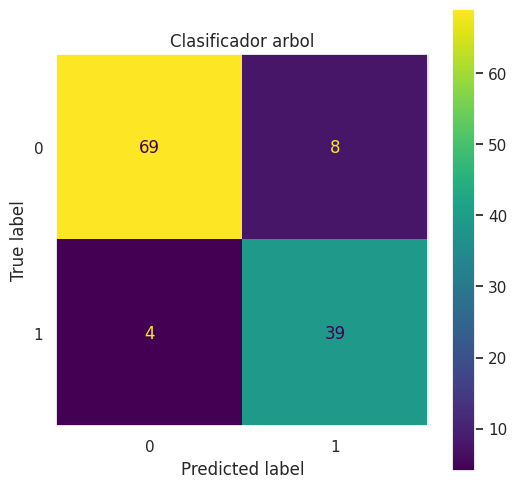

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree,
                              display_labels=best_tree_social.classes_)

fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Clasificador arbol");

Comparando los modelos que realizamos:

- Modelo de regresión logística
- Modelo kNN
- Árbol de decisión

Las métricas que obtuvimos son:

| Modelo              |  F0.5 | Precisión | Especificidad |
|---------------------|-------|-----------|---------------|
| Regresión logistica | 0.792 |   0.829   |     0.674     |
| kNN                 | 0.874 |   0.866   |     0.906     |
| Arbol de decisión   | 0.884 |   0.830   |     0.907     |

Los valores de la tabla se obtuvieron del trabajo practico 2 tanto los valores de regresión logistica como KNN
En función a estos resultados y complejidad de los modelos, discutir cual es el mejor modelo.